In [2]:
#Installing and importing required libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
plt.style.use('default')

!pip install librosa 
import librosa


Epoch 0 	| Train Loss = 0.064 	| SNR = 2.39
Epoch 10 	| Train Loss = 0.026 	| SNR = 6.67
Epoch 20 	| Train Loss = 0.015 	| SNR = 8.98
Epoch 30 	| Train Loss = 0.01 	| SNR = 10.42
Epoch 40 	| Train Loss = 0.009 	| SNR = 10.97
Epoch 50 	| Train Loss = 0.007 	| SNR = 11.84
Epoch 60 	| Train Loss = 0.009 	| SNR = 10.53
Epoch 70 	| Train Loss = 0.006 	| SNR = 12.69
Epoch 80 	| Train Loss = 0.005 	| SNR = 13.04
Epoch 90 	| Train Loss = 0.005 	| SNR = 13.29
Epoch 100 	| Train Loss = 0.005 	| SNR = 13.11
Epoch 110 	| Train Loss = 0.004 	| SNR = 13.83
Epoch 120 	| Train Loss = 0.004 	| SNR = 13.64
Epoch 130 	| Train Loss = 0.004 	| SNR = 13.73
Epoch 140 	| Train Loss = 0.005 	| SNR = 13.46
Epoch 150 	| Train Loss = 0.005 	| SNR = 13.33
Epoch 160 	| Train Loss = 0.005 	| SNR = 13.0
Epoch 170 	| Train Loss = 0.004 	| SNR = 13.82
Epoch 180 	| Train Loss = 0.004 	| SNR = 14.05
Epoch 190 	| Train Loss = 0.005 	| SNR = 13.4
Epoch 200 	| Train Loss = 0.004 	| SNR = 14.32
Epoch 210 	| Train Loss = 0.00

Text(0.5, 1.0, 'Convergence')

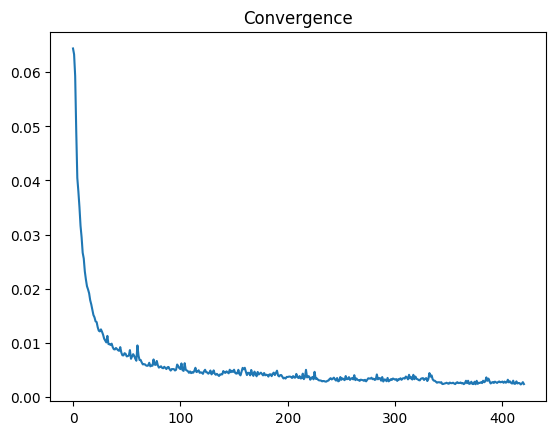

In [0]:
#Question 2
sn, sr=librosa.load('train_dirty_male.wav', sr=None)
X=librosa.stft(sn, n_fft=1024, hop_length=512)
s, sr=librosa.load('train_clean_male.wav', sr=None)
S=librosa.stft(s, n_fft=1024, hop_length=512)

x_train = np.transpose(np.abs(X))
y_train = np.transpose(np.abs(S))

def snr(x,s,p):
  _,phase = librosa.magphase(x)
  #s=librosa.istft(s * phase)
  #print(p * phase,np.flipud((p * phase)[1:].conj()))
#   e = p * phase
#   f = np.flipud((p * phase)[1:512].conj())
#   print(e.shape,f.shape)
#   d =np.concatenate((e,f),axis=0) 
#   print(d.shape)
  #print(p.shape)
  p=librosa.istft(p*phase, hop_length=512,length=len(s))
  #print(p.shape)
  a = np.matmul(np.transpose(s),s)
  b = np.matmul(np.transpose(s-p),s-p)
  return 10*np.log10(a/b)





s1, sr=librosa.load('test_x_01.wav', sr=None)
S1=librosa.stft(s1, n_fft=1024, hop_length=512)
x_test_1 = np.transpose(np.abs(S1))
s2, sr=librosa.load('test_x_02.wav', sr=None)
S2=librosa.stft(s2, n_fft=1024, hop_length=512)
x_test_2 = np.transpose(np.abs(S2))



#next_batch
def next_batch(x,y,start,batch_size):
    return x[start:start + batch_size], y[start:start + batch_size]
                                  
#Network Parameters
n_input = x_train.shape[1]                                  
n_classes = y_train.shape[1]                             
hidden_units = 256

#Defining hyperparamters
batch_size = 100
n_epoch = 421
display_f = 10
learning_rate = 0.001

#Calc number of iterations in each epoch
n_iter = len(x_train)//batch_size
                                  
#layer function
def layer(x,hidden_units,name,relu_flag=True):
  input_dim = int(x.get_shape()[1])
  #init = tf.truncated_normal([input_dim,hidden_units],stddev=0.01)  
  w = tf.get_variable('w_' + name,dtype=tf.float32,initializer=\
                      tf.truncated_normal([input_dim,hidden_units],stddev=0.01))
  b = tf.get_variable('b_' + name,dtype=tf.float32,\
                      initializer=tf.constant(0., shape=[hidden_units], dtype=tf.float32))
  if relu_flag ==True:
     return tf.nn.relu(x@w+b)
  else:
     return tf.nn.softmax(x@w+b)
  
#Creating the graph
tf.reset_default_graph()
x = tf.placeholder(tf.float32,[None,x_train.shape[1]])
y = tf.placeholder(tf.float32,[None,y_train.shape[1]])

layer_1 = layer(x,hidden_units,'layer_1',True)
layer_2 = layer(layer_1,hidden_units,'layer_2',True)
layer_out = layer(layer_2,n_classes,'output',True)

#loss, optimizer & accuracy
loss = tf.reduce_mean(tf.losses.mean_squared_error(y,layer_out))
train_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
#correct_pred = tf.equal(tf.argmax(layer_out, 1), tf.argmax(y, 1))
accuracy, acc = tf.metrics.accuracy(labels=y, predictions= layer_out)

saver = tf.train.Saver()

with tf.Session()  as sess:
  err = np.zeros(n_epoch)
  tf.global_variables_initializer().run() 
  tf.local_variables_initializer().run()
  for epoch in range(n_epoch):
   # print('Epoch ', str(epoch))
#     print('_'*30)
    
    for itr in range(n_iter):
      
      
      x_batch,y_batch = next_batch(x_train,y_train,itr*batch_size,batch_size)

      sess.run(train_optimizer, feed_dict={x:x_batch,y:y_batch})
      
#       if itr%display_f == 0:
#         batch_loss, batch_accuracy = sess.run([loss,accuracy],feed_dict={x:x_batch,y:y_batch})
        
#         print("Iteration", str(itr), "\t| Batch Loss =", str(round(batch_loss,2)), "\t| Batch Accuracy =", str(round(batch_accuracy,2)))
    #Validation after each epoch
#     valid_loss, valid_accuracy = sess.run([loss,accuracy],feed_dict={x:x_valid,y:y_valid})
#     print('_'*30)      
#     print("Epoch", str(epoch), "\t| Validation Loss =", str(round(valid_loss,2)), "\t| Validation Accuracy =", str(round(valid_accuracy,2)))
#     print('_'*30)
    #Test loss and accuracy
    
    err[epoch],train_accuracy,out = sess.run([loss,accuracy,layer_out],feed_dict={x:x_train,y:y_train})
    d = np.transpose(out)
    snd = snr(X,s,d)
    #test_accuracy = sess.run([loss,accuracy],feed_dict={x:x_test,y:y_test})
    
    saver.save(sess, "Model_2")
    if epoch%display_f == 0:
      print("Epoch", str(epoch), "\t| Train Loss =", str(round(err[epoch],3)), "\t| SNR =", str(round(snd,2)))
    
    
  #y_probs, y_indices = sess.run(tf.nn.top_k(layer_out, k=10), feed_dict={x:x_test[:1000],y:y_test[:1000]})
plt.figure()
plt.plot(err)
plt.title('Convergence')    
    




The neural network has 2 hidden layers and the follwoing hyperparamters batch_size = 100 | n_epoch = 421 |
learning_rate = 0.001. Trincated normal with standard deviation of 0.01 was used to intialize weights. .The training loss comes down to 0.002 at the end of 420 epochs and the SNR on the groundtruth is 16.2

In [0]:
#First test file
with tf.Session() as sess:
  saver.restore(sess, "Model_2")
  out =sess.run(tf.transpose(layer_out), feed_dict={x:x_test_1})  
_,phase = librosa.magphase(S1)
p=librosa.istft(out*phase, hop_length=512,length=len(s1))   
librosa.output.write_wav('test_s_01_recons.wav', p, sr)
#Code to download the reconstructed noise free file
# from google.colab import files
# files.download('test_s_01_recons.wav')
#Audio display
from IPython.display import *
Audio("test_s_01_recons.wav", autoplay=False)

INFO:tensorflow:Restoring parameters from Model_2


In [0]:
#Second test file
with tf.Session() as sess:
  saver.restore(sess, "Model_2")
  out =sess.run(tf.transpose(layer_out), feed_dict={x:x_test_2})  
_,phase = librosa.magphase(S2)
p=librosa.istft(out*phase, hop_length=512,length=len(s2))   
librosa.output.write_wav('test_s_02_recons.wav', p, sr)
# from google.colab import files
# files.download('test_s_02_recons.wav')
from IPython.display import *
Audio("test_s_02_recons.wav", autoplay=False)  


  


INFO:tensorflow:Restoring parameters from Model_2


The output of first test file is noise free and with minute distortion whereas the second test file the output is a little distorted with small chip noise in the middle. Both of them are better interms of noise compared to the original versions.